# Evasion Attack against SVM

In [1]:
import os
import time
import copy

import numpy as np
import sklearn
from sklearn import datasets
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from aijack.attack import Evasion_attack_sklearn

In [2]:
mnist = datasets.fetch_openml("mnist_784", version=1, data_home=".", return_X_y=True)
imagedata, labeldata = mnist[0].values, mnist[1].values

index_3 = [i for i, x in enumerate(labeldata) if x == "3"]
index_7 = [i for i, x in enumerate(labeldata) if x == "7"]
image_data_3_7 = imagedata[index_3 + index_7]
label_data_3_7 = labeldata[index_3 + index_7]

(
    imagedata_training,
    imagedata_validation,
    labeldata_training,
    labeldata_validation,
) = train_test_split(image_data_3_7, label_data_3_7, test_size=0.2, shuffle=True)

imagedata_training = imagedata_training / 255.0
imagedata_validation = imagedata_validation / 255.0

X_train = imagedata_training[:5000]
y_train = labeldata_training[:5000]
X_valid = imagedata_validation[:500]
y_valid = labeldata_validation[:500]

## Train the target classification model

In [3]:
clf = SVC(kernel="linear")
clf.fit(X_train, y_train)

predict = clf.predict(X_valid)

ac_score = metrics.accuracy_score(y_valid, predict)
cl_report = metrics.classification_report(y_valid, predict)
print(cl_report)

              precision    recall  f1-score   support

           3       1.00      0.96      0.98       220
           7       0.97      1.00      0.98       280

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



## Evasion Attack

In [4]:
X_minus_1 = X_train[np.where(y_train == "3")]
attacker = Evasion_attack_sklearn(
    target_model=clf,
    X_minus_1=X_minus_1,
    dmax=(5000 / 255) * 2.5,
    max_iter=300,
    gamma=1 / (X_train.shape[1] * np.var(X_train)),
    lam=10,
    t=0.5,
    h=10,
)

x0 = X_valid[np.where(y_valid == "7")[0][0]]
xm, g_list = attacker.attack(copy.copy(x0))

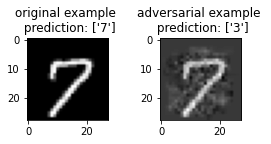

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2))


axes[0].imshow(x0.reshape(28, 28), cmap="gray")
axes[0].set_title(f"original example \n prediction: {clf.predict(x0.reshape(1, -1))}")

axes[1].imshow(xm.reshape(28, 28), cmap="gray")
axes[1].set_title(
    f"adversarial example \n prediction: {clf.predict(xm.reshape(1, -1))}"
)

fig.tight_layout()
# fig.savefig("output_10.png")
fig.show()